# Evaluation Of Duet Benchmarking Results from Distributed Database "Cassandra"

### Imports

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import os
from pathlib import Path

### Import Benchmarking Measurements as csv file and create Pandas Dataframe for further Analysis

In [55]:
cwd = Path.cwd()
filepath = os.path.join(cwd, "Results", "1mops_3t", "load_measurements.csv")
print(filepath)
df = pd.read_csv(filepath)

C:\Users\Felix Medicus\Desktop\Thesis_MCC\DuetBenchmarking\Results\Results\1mops_3t\load_measurements.csv


### Insert latencies in ms into the measurement table

In [56]:
df["latency_ms"] = df["received"]- df["sent"]

### Restructure Timeline

In [57]:
firstSent = df["sent"].min()
df["sent_sec"] = (df["sent"] - firstSent)/1000

### Create Function to prune Measurements

In [58]:
def pruneMeasurements(dataframe): 
    print("Hello from the other side")
    
pruneMeasurements(df)


Hello from the other side


### Create subsets of dataframe (for Version A and B, and for each worker for Version A and B) 

In [59]:
dfA1 = df.loc[(df["workerId"] == "w1-vA")]
dfA2 = df.loc[(df["workerId"] == "w2-vA")]
dfA3 = df.loc[(df["workerId"] == "w3-vA")]
dfB1 = df.loc[(df["workerId"] == "w1-vB")]
dfB2 = df.loc[(df["workerId"] == "w2-vB")]
dfB3 = df.loc[(df["workerId"] == "w3-vB")]
dfA = df.loc[(df["workerId"] == "w1-vA") | (df["workerId"] == "w2-vA") | (df["workerId"] == "w3-vA")]
dfB = df.loc[(df["workerId"] == "w1-vB") | (df["workerId"] == "w2-vB") | (df["workerId"] == "w3-vB")]

### Return benchmark run time (First request send to last response received)

In [60]:
totalTime = df["received"].max() - df["sent"].min()
print(totalTime/1000/60, "minuten")

13.918033333333334 minuten


In [61]:
dfA.describe()

,sent,received,latency_ms,sent_sec
count,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000
mean,1.657983e+12,1.657983e+12,7.238528,344.209698
std,2.534762e+05,2.534780e+05,22.615543,253.476205
min,1.657983e+12,1.657983e+12,0.000000,0.000000
25%,1.657983e+12,1.657983e+12,1.000000,91.572750
50%,1.657983e+12,1.657983e+12,2.000000,313.403000
75%,1.657983e+12,1.657983e+12,4.000000,569.134000
max,1.657984e+12,1.657984e+12,922.000000,820.041000


In [62]:
dfB.describe()

,sent,received,latency_ms,sent_sec
count,1.000000e+06,1.000000e+06,1000000.000000,1000000.000000
mean,1.657983e+12,1.657983e+12,7.407500,353.548984
std,2.608219e+05,2.608236e+05,22.888611,260.821903
min,1.657983e+12,1.657983e+12,0.000000,0.002000
25%,1.657983e+12,1.657983e+12,1.000000,93.207750
50%,1.657983e+12,1.657983e+12,2.000000,321.164500
75%,1.657983e+12,1.657983e+12,4.000000,584.904250
max,1.657984e+12,1.657984e+12,688.000000,835.079000


### Min. Latencies for Worker 2 (A & B)

In [63]:
dfA2.loc[dfA2["latency_ms"].idxmin()]

workerId                                        w2-vA
queryType                                      INSERT
queryId          8e002a8a-3a7b-4a43-a399-1902f11706be
sent                                    1657982802866
received                                1657982802866
target-region                                 unknown
latency_ms                                          0
sent_sec                                        3.534
Name: 668534, dtype: object

In [64]:
dfB2.loc[dfB2["latency_ms"].idxmin()]

workerId                                        w2-vB
queryType                                      INSERT
queryId          e9376032-08f1-4af0-b5b4-bdc86be8246a
sent                                    1657982803574
received                                1657982803574
target-region                                 unknown
latency_ms                                          0
sent_sec                                        4.242
Name: 670112, dtype: object

### Some checks

#### Time difference in ms when first query was sent by worker-1 to Version A and B 

In [65]:

dfA2["sent"].min() - dfB2["sent"].min()

0

#### Time difference in ms when last query was sent by worker-1 to Version A and B 

In [66]:
dfA1["sent"].max() - dfB1["sent"].max() 


-28567

## Create Figures 

### Create Boxplots

In [67]:
sns.set_theme(style="darkgrid")

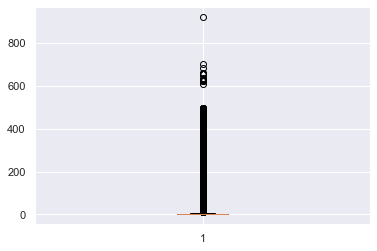

In [68]:
ax = plt.boxplot(x=dfA["latency_ms"])


### Create Flowchart

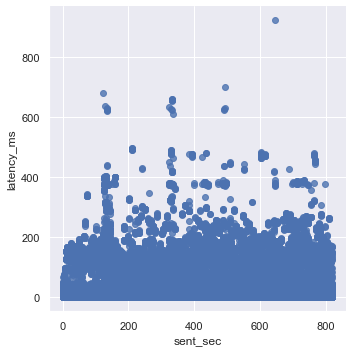

In [69]:
sns.lmplot(x='sent_sec', y='latency_ms', data=dfA, fit_reg=False)